##Importações iniciais

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

##Carregando dataset (test + training)

In [2]:
training = pd.read_csv("https://raw.githubusercontent.com/gabrielaallemao/mvp3/main/train.csv")
testing = pd.read_csv("https://raw.githubusercontent.com/gabrielaallemao/mvp3/main/test.csv")

training.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


###Transformação e organização de dados

In [3]:
# Observando quantidade de células com valores nulos
def null_table(training, testing):
    print("Training Data Frame")
    print(pd.isnull(training).sum())
    print(" ")
    print("Testing Data Frame")
    print(pd.isnull(testing).sum())

null_table(training, testing)

Training Data Frame
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
 
Testing Data Frame
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [4]:
#Excluindo as colunas com muitas células nulas para facilitar os cálculos

training.drop(labels = ["Cabin", "Ticket"], axis = 1, inplace = True)
testing.drop(labels = ["Cabin", "Ticket"], axis = 1, inplace = True)

null_table(training, testing)

Training Data Frame
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
dtype: int64
 
Testing Data Frame
PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Fare            1
Embarked        0
dtype: int64


In [5]:
# Preenchendo idades nulas com médias para facilitar os cálculos
training["Age"].fillna(training["Age"].median(), inplace = True)
testing["Age"].fillna(testing["Age"].median(), inplace = True)
training["Embarked"].fillna("S", inplace = True)
testing["Fare"].fillna(testing["Fare"].median(), inplace = True)

null_table(training, testing)

Training Data Frame
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64
 
Testing Data Frame
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64


###Interpretação inicial dos dados

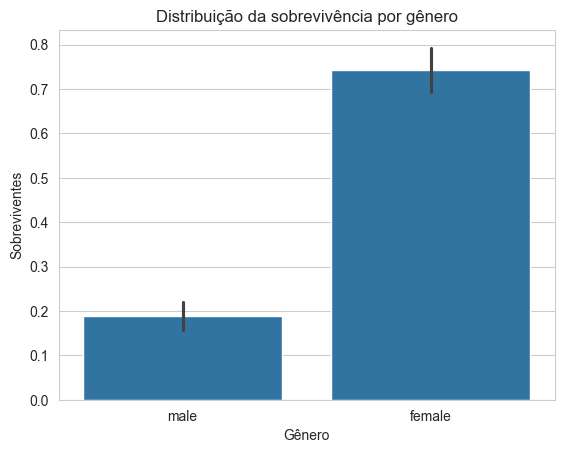

Total de passageiros que sobreviveram ao naufrágio: 342
Porcentagem de mulheres que sobreviveram:
68.13 %
Porcentagem de homens que sobreviveram:
31.87 %


In [6]:
# Calculando a taxa de sobrevivência por gênero
sns.barplot(x="Sex", y="Survived", data=training)
plt.title("Distribuição da sobrevivência por gênero")
plt.ylabel("Sobreviventes")
plt.xlabel("Gênero")
plt.show()

total_survived_females = training[training.Sex == "female"]["Survived"].sum()
total_survived_males = training[training.Sex == "male"]["Survived"].sum()

survived_females_rate = "%.2f" % ((total_survived_females/(total_survived_females + total_survived_males))*100)
survived_males_rate = "%.2f" % ((total_survived_males/(total_survived_females + total_survived_males))*100)

print("Total de passageiros que sobreviveram ao naufrágio: " + str((total_survived_females + total_survived_males)))
print("Porcentagem de mulheres que sobreviveram:")
print(survived_females_rate, '%')
print("Porcentagem de homens que sobreviveram:")
print(survived_males_rate, '%')

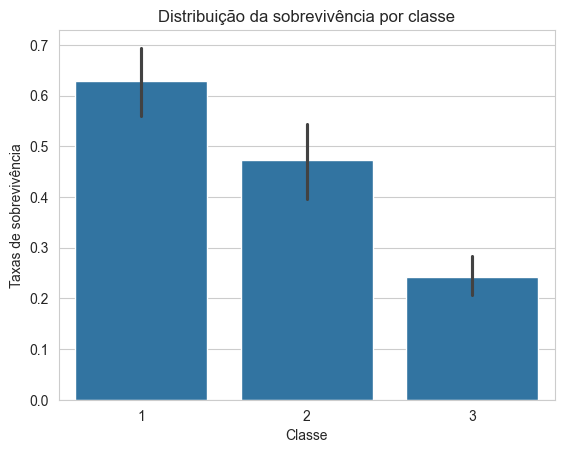

Total de passageiros que sobreviveram ao naufrágio: 342
Porcentagem de passageiros da Class 1 que sobreviveram:
39.77 %
Porcentagem de passageiros da Class 3 que sobreviveram:
25.44 %
Porcentagem de passageiros da Class 3 que sobreviveram:
34.80 %


In [7]:
# Calculando a taxa de sobrevivência por classe
sns.barplot(x="Pclass", y="Survived", data=training)
plt.ylabel("Taxas de sobrevivência")
plt.xlabel("Classe")
plt.title("Distribuição da sobrevivência por classe")
plt.show()

total_survived_one = training[training.Pclass == 1]["Survived"].sum()
total_survived_two = training[training.Pclass == 2]["Survived"].sum()
total_survived_three = training[training.Pclass == 3]["Survived"].sum()
total_survived_class = total_survived_one + total_survived_two + total_survived_three

rate_survived_one = "%.2f" % ((total_survived_one/total_survived_class)*100)
rate_survived_two = "%.2f" % ((total_survived_two/total_survived_class)*100)
rate_survived_three = "%.2f" % ((total_survived_three/total_survived_class)*100)

print("Total de passageiros que sobreviveram ao naufrágio: " + str(total_survived_class))
print("Porcentagem de passageiros da Class 1 que sobreviveram:")
print(rate_survived_one, '%')
print("Porcentagem de passageiros da Class 3 que sobreviveram:")
print(rate_survived_two, '%')
print("Porcentagem de passageiros da Class 3 que sobreviveram:")
print(rate_survived_three, '%')


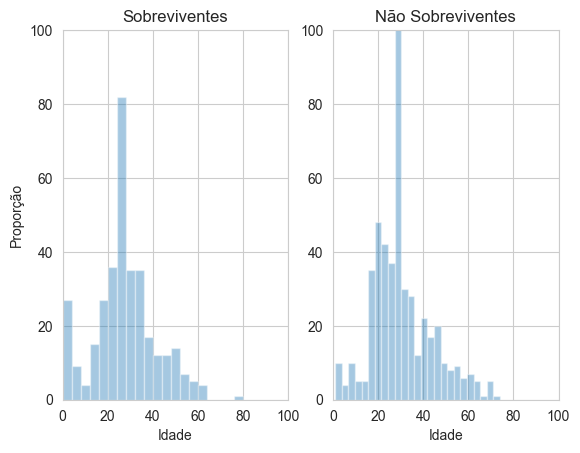

In [8]:
#Idades dos passageiros
survived_ages = training[training.Survived == 1]["Age"]
not_survived_ages = training[training.Survived == 0]["Age"]
plt.subplot(1, 2, 1)
sns.distplot(survived_ages, kde=False)
plt.axis([0, 100, 0, 100])
plt.title("Sobreviventes")
plt.ylabel("Proporção")
plt.xlabel("Idade")
plt.subplot(1, 2, 2)
sns.distplot(not_survived_ages, kde=False)
plt.axis([0, 100, 0, 100])
plt.title("Não Sobreviventes")
plt.xlabel("Idade")
plt.show()

In [9]:
#Transformando strings em int para modelagem de dados
training.loc[training["Sex"] == "male", "Sex"] = 0
training.loc[training["Sex"] == "female", "Sex"] = 1

training.loc[training["Embarked"] == "S", "Embarked"] = 0
training.loc[training["Embarked"] == "C", "Embarked"] = 1
training.loc[training["Embarked"] == "Q", "Embarked"] = 2

testing.loc[testing["Sex"] == "male", "Sex"] = 0
testing.loc[testing["Sex"] == "female", "Sex"] = 1

testing.loc[testing["Embarked"] == "S", "Embarked"] = 0
testing.loc[testing["Embarked"] == "C", "Embarked"] = 1
testing.loc[testing["Embarked"] == "Q", "Embarked"] = 2

training["FamSize"] = training["SibSp"] + training["Parch"] + 1
testing["FamSize"] = testing["SibSp"] + testing["Parch"] + 1

training["IsAlone"] = training.FamSize.apply(lambda x: 1 if x == 1 else 0)
testing["IsAlone"] = testing.FamSize.apply(lambda x: 1 if x == 1 else 0)

testing.sample(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamSize,IsAlone
342,1234,3,"Sage, Mr. John George",0,27.0,1,9,69.5500,0,11,0
74,966,1,"Geiger, Miss. Amalie",1,35.0,0,0,211.5000,1,1,1
125,1017,3,"Cribb, Miss. Laura Alice",1,17.0,0,1,16.1000,0,2,0
217,1109,1,"Wick, Mr. George Dennick",0,57.0,1,1,164.8667,0,3,0
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,0,0,9.6875,2,1,1
269,1161,3,"Pokrnic, Mr. Mate",0,17.0,0,0,8.6625,0,1,1
243,1135,3,"Hyman, Mr. Abraham",0,27.0,0,0,7.8875,0,1,1
301,1193,2,"Malachard, Mr. Noel",0,27.0,0,0,15.0458,1,1,1
310,1202,3,"Cacic, Mr. Jego Grga",0,18.0,0,0,8.6625,0,1,1
197,1089,3,"Nilsson, Miss. Berta Olivia",1,18.0,0,0,7.7750,0,1,1


###Separação em conjunto de treino e conjunto de teste

In [10]:
features = ["Pclass", "Sex", "Age", "Embarked", "Fare"]
X_train = training[features]
y_train = training["Survived"]
X_test = testing[features]

X_training, X_valid, y_training, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

##Modelagem de dados

In [11]:
svc_clf = SVC()
svc_clf.fit(X_training, y_training)
pred_svc = svc_clf.predict(X_valid)
acc_svc = accuracy_score(y_valid, pred_svc)

print(acc_svc)

0.7094972067039106


In [12]:
linsvc_clf = LinearSVC()
linsvc_clf.fit(X_training, y_training)
pred_linsvc = linsvc_clf.predict(X_valid)
acc_linsvc = accuracy_score(y_valid, pred_linsvc)

print(acc_linsvc)

0.7877094972067039


In [13]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_training, y_training)
pred_rf = rf_clf.predict(X_valid)
acc_rf = accuracy_score(y_valid, pred_rf)

print(acc_rf)

0.8379888268156425


In [14]:
logreg_clf = LogisticRegression()
logreg_clf.fit(X_training, y_training)
pred_logreg = logreg_clf.predict(X_valid)
acc_logreg = accuracy_score(y_valid, pred_logreg)

print(acc_logreg)

0.7988826815642458


In [15]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_training, y_training)
pred_knn = knn_clf.predict(X_valid)
acc_knn = accuracy_score(y_valid, pred_knn)

print(acc_knn)

0.7318435754189944


In [16]:
gnb_clf = GaussianNB()
gnb_clf.fit(X_training, y_training)
pred_gnb = gnb_clf.predict(X_valid)
acc_gnb = accuracy_score(y_valid, pred_gnb)

print(acc_gnb)

0.7877094972067039


In [17]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_training, y_training)
pred_dt = dt_clf.predict(X_valid)
acc_dt = accuracy_score(y_valid, pred_dt)

print(acc_dt)

0.7932960893854749


Avaliação e comparação dos resultados

In [18]:
model_performance = pd.DataFrame({
    "Model": ["SVC", "Linear SVC", "Random Forest",
              "Logistic Regression", "K Nearest Neighbors", "Gaussian Naive Bayes",
              "Decision Tree"],
    "Accuracy": [acc_svc, acc_linsvc, acc_rf,
              acc_logreg, acc_knn, acc_gnb, acc_dt]
})

model_performance.sort_values(by="Accuracy", ascending=False)

,Model,Accuracy
2,Random Forest,0.837989
3,Logistic Regression,0.798883
6,Decision Tree,0.793296
1,Linear SVC,0.787709
5,Gaussian Naive Bayes,0.787709
4,K Nearest Neighbors,0.731844
0,SVC,0.709497


###Criação e avaliação de modelos: linha base

KNN: 0.699176 (0.037122)
CART: 0.790050 (0.040475)
NB: 0.776592 (0.045580)
SVM: 0.673446 (0.044401)


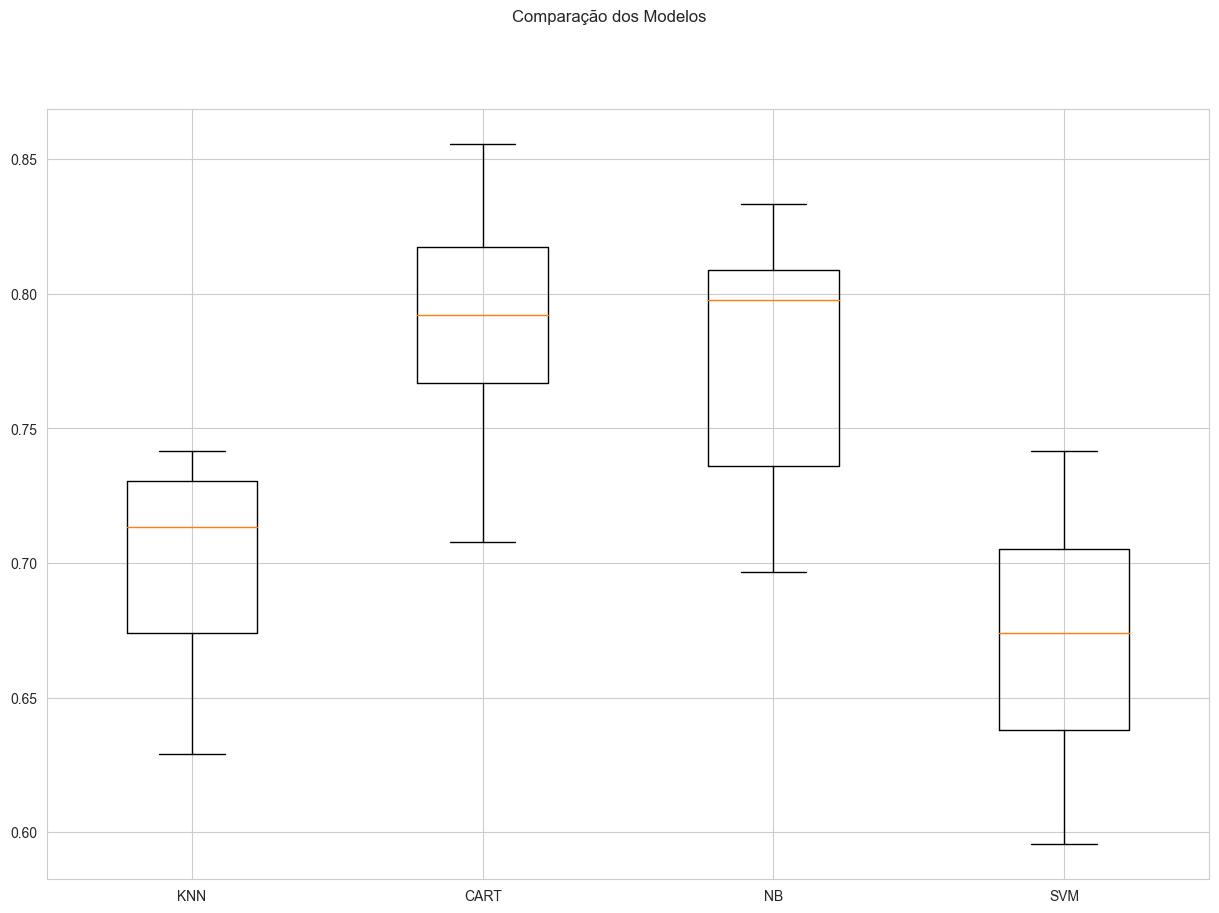

In [19]:
np.random.seed(7)
seed = 7
models = []

models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

results = []
names = []

scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed)

for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

###Criação e avaliação de modelos: dados padronizados e normalizados

KNN-orig: 0.699 (0.037)
CART-orig: 0.790 (0.040)
NB-orig: 0.777 (0.046)
SVM-orig: 0.673 (0.044)
KNN-padr: 0.819 (0.036)
CART-padr: 0.784 (0.039)
NB-padr: 0.777 (0.046)
SVM-padr: 0.825 (0.019)
KNN-norm: 0.799 (0.040)
CART-norm: 0.792 (0.050)
NB-norm: 0.777 (0.046)
SVM-norm: 0.811 (0.021)


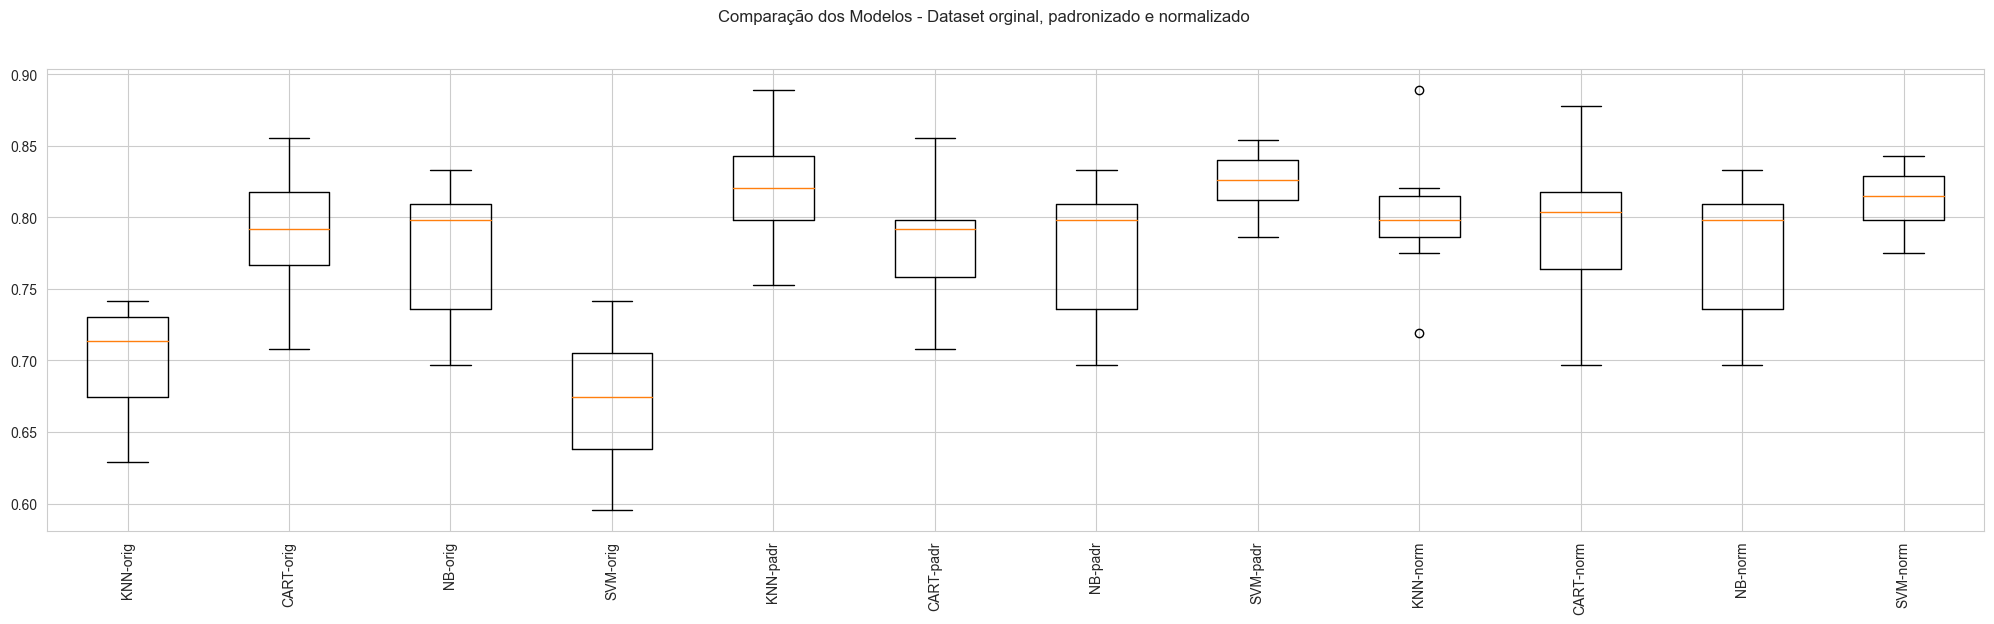

In [20]:
np.random.seed(7)

results = []
names = []
pipelines = []

knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

Otimização dos hiperparâmetros

In [21]:

np.random.seed(7)

pipelines = []

# Definindo os componentes do pipeline
knn = ('KNN', KNeighborsClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('knn-orig', Pipeline(steps=[knn])))
pipelines.append(('knn-padr', Pipeline(steps=[standard_scaler, knn])))
pipelines.append(('knn-norm', Pipeline(steps=[min_max_scaler, knn])))

param_grid = {
    'KNN__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Sem tratamento de missings: knn-orig - Melhor: 0.745218 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 7}
Sem tratamento de missings: knn-padr - Melhor: 0.819226 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 5}
Sem tratamento de missings: knn-norm - Melhor: 0.809189 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 19}


Finalização do Modelo

In [22]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = KNeighborsClassifier(metric='manhattan', n_neighbors=17)
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test)
predictions = model.predict(rescaledTestX)
print(accuracy_score)

<function accuracy_score at 0x1196addc0>


In [23]:
# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model.fit(rescaledX, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=17, p=2,
                     weights='uniform')

In [24]:
import joblib
lr = LogisticRegression
knn = KNeighborsClassifier

# Salvando o modelo em LR e KNN
joblib.dump(lr, "lr_titanic.pkl")
joblib.dump(knn, "knn_titanic.pkl")

['knn_titanic.pkl']

Aqui tivemos como inicial problema um naufrágio, visto que conhecemos a história de que o navio Titanic não tinha botes o suficiente para salvar a todos os passageiros, quais seriam os mais propensos a sobreviver, tendo inicialmente que 342 pessoas sobreviveram.

Inicialmente calculamos a taxa de sobrevivência por gênero, uma vez que culturalmente em situação de perigo, as mulheres e as crianças seriam as primeiras a irem para os botes. Os cálculos então, confirmam que 68.13% dos sobreviventes eram mulheres.

Vemos também uma discrepância quando em relação às classes, já que os cálculos mais uma vez confirmam que passageiros da 1ª classe tem mais chances de sobreviver (39.77%).

Além disso, há uma curiosidade em decorrência da proporção de sobrevivência por idade, visto que a maioria dos passageiros estavam entre seus 20 a 40 anos, e passageiros de idade inferior a 20 anos (ou seja, crianças), tiveram maior taxa de sobrevivência.

A acurácia dos modelos se manteve, em média, maior que 0.75 (ou 75%), levando em consideração a manipulação dos dados de forma que os cálculos ficassem mais fáceis de interpretar pela ML, como o arredondamento de idades nulas e a binarização de dados como o porto de embarque e o gênero, que influenciaria no cálculo final.